<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/05_Transfer_Learning_with_TensorFlow_Part_2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
!nvidia-smi

Wed Mar 24 02:38:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |   4930MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with Tensorflow: Fine Tuning 
In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning which is **fine-tuning**.

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the **Keras Functional API** (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- **Data augmentation** (how to make your training dataset more diverse without adding more data)

- Running a **series of modelling experiments** on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the **ModelCheckpoint callback** to save intermediate training results
- Compare model experiments results using TensorBoard

## Creating helper function
In previous notebooks, we've created a bunch of helper functions now we could re-write them all. However this is tedious. So it's a good idea to put all those function you want to use in a script, with that we can import them later depending upon our use. 

In [104]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-24 02:38:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-24 02:38:57 (107 MB/s) - ‘helper_functions.py.2’ saved [9304/9304]



In [105]:
# Import helper function 
from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data , walk_through_dir

> **Dan Note:** If you're running this notebook in Colab, when it times out in Colab will delete `helper_functions.py` so you'll have to redownload it if you want access to your helper function. 

## Let's get some data 
This time we're going to see how to use the pre-trained models within `tf.keras.applications` and apply them to our own problem recognizing images of food. 

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [106]:
# Get 10% of training data of 10 classes of Food101 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2021-03-24 02:38:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 172.217.2.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2021-03-24 02:38:58 (201 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [107]:
# Check out how many images and sub directories are in our dataset 
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [108]:
# Create training and test directory path 
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [109]:
import tensorflow as tf

# Global image size , batch 
IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

# Using the image_dataset_from_directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir , 
                                                                            image_size = IMG_SIZE , 
                                                                            label_mode = 'categorical' , 
                                                                            batch_size = BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                           image_size = IMG_SIZE,  
                                                                           label_mode = 'categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [110]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [111]:
# Check out class names of our dataset 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [112]:
# Seeing an example of batch
for images ,labels in train_data_10_percent.take(1): # take unravel a batch 
  print(images , labels)

tf.Tensor(
[[[[1.09273117e+02 1.16273117e+02 1.08273117e+02]
   [1.08170601e+02 1.15170601e+02 1.07170601e+02]
   [1.08394928e+02 1.15394928e+02 1.07394928e+02]
   ...
   [9.05687790e+01 1.84549072e+02 2.32921661e+02]
   [9.73765717e+01 1.87936203e+02 2.37656387e+02]
   [9.69249649e+01 1.85398376e+02 2.37718796e+02]]

  [[1.04796082e+02 1.14930801e+02 1.03526627e+02]
   [1.04515152e+02 1.15039543e+02 1.02466354e+02]
   [1.01376915e+02 1.11376915e+02 1.00376915e+02]
   ...
   [8.93655777e+01 1.83541962e+02 2.31816498e+02]
   [8.91344147e+01 1.82707581e+02 2.31183197e+02]
   [9.12271271e+01 1.90226227e+02 2.39152542e+02]]

  [[1.00830200e+02 1.11830200e+02 9.56159134e+01]
   [1.07106667e+02 1.18106667e+02 1.01892380e+02]
   [1.04729912e+02 1.15729912e+02 9.95156250e+01]
   ...
   [8.91526108e+01 1.83387833e+02 2.29485886e+02]
   [8.61629639e+01 1.80837845e+02 2.26549591e+02]
   [8.14375916e+01 1.84848129e+02 2.29879227e+02]]

  ...

  [[1.90123154e+02 1.67544678e+02 9.15135880e+01]
   [1

## Model 0: Building a Transfer Learning model (Feature Extraction) using the Keras Functional API

The sequential API is straight-forward, it runs our layers in Sequential order.

But the functional API gives us more flexibility with our model. 
https://www.tensorflow.org/guide/keras/functional

In [113]:
# 1. Create a base model with tf.keras.applications 
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# 2. Freeze the base_model  (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model 
inputs = tf.keras.layers.Input(shape = (224 , 224, 3) , name = 'input_layer')

# 4. If you're using a model like ResNet50V2 you will need to normalize the inputs (no need for EfficientNet)
# x = tf.keras.experimental.preprocessing.Rescaling(1 / 255.)(inputs)

# 5. Pass the inputs to the base model 
x = base_model(inputs)
print(f'Shape after passing inputs through base_model {x.shape}')

# 6. Average Pool the outputs of the base model (aggregate all the most important info, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x) # atlast multiplying means passing onto another layer
print(f'Shape aftr Global Average Pooling 2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10 , activation ='softmax' , name ='output_layer')(x)

# 8. Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs , outputs)

# 9. Compile the model 
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# 10. Fit and save the history 
history_0 = model_0.fit(train_data_10_percent , 
                        steps_per_epoch = len(train_data_10_percent) , 
                        epochs = 5 , 
                        validation_data = test_data_10_percent , 
                        validation_steps = int( 0.25 *len(test_data_10_percent)) , 
                        callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                 '10_percent')])

Shape after passing inputs through base_model (None, 7, 7, 1280)
Shape aftr Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20210324-023903
Epoch 1/5
24/24 [==============================] - 13s 332ms/step - loss: 2.1319 - accuracy: 0.2672 - val_loss: 1.3517 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 6s 226ms/step - loss: 1.2598 - accuracy: 0.7033 - val_loss: 0.9309 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 6s 227ms/step - loss: 0.8828 - accuracy: 0.7995 - val_loss: 0.7568 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 6s 226ms/step - loss: 0.7071 - accuracy: 0.8288 - val_loss: 0.6916 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 6s 227ms/step - loss: 0.6047 - accuracy: 0.8568 - val_loss: 0.6198 - val_accuracy: 0.8438


In [114]:
# Evaluate on the full test data 
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 10s 120ms/step - loss: 0.6101 - accuracy: 0.8412


[0.6101043820381165, 0.8411999940872192]

In [115]:
# Check the layers in our base model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_6
1 rescaling_5
2 normalization_5
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [116]:
# Summary of the base model 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, None, None, 3 7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_5[0][0]            
_____________________________________________________________________________________

In [117]:
# Summary of the model_0 
model_0.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


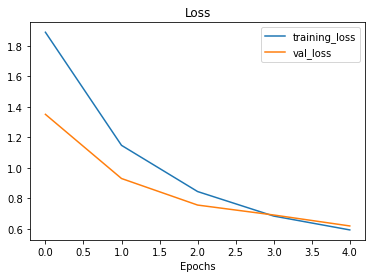

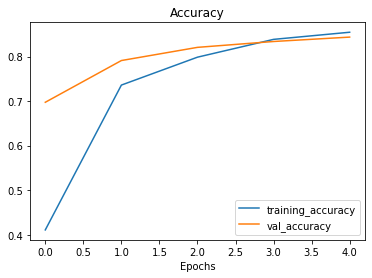

In [118]:
# Check our our model's training curves 
plot_loss_curves(history_0)

## Getting a feature vector from the trained model 

Let's demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape (None , 7 , 7 , 1280)....

But when it passes through GlobalAveragePooling2D layer it turns into (None , 1280). 

Let's use a similar shape tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D. 

In [119]:
# Define the input shape 
input_shape = (1 , 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor to a GlobalAveragePool2d Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # Same like using the functional api
print(f'2D Global average pooled random tensor:\n {global_average_pooled_tensor} ')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 


In [120]:
# Check the shape of different tensors 
print(f'Shape of the input_tensor: {input_tensor.shape}')
print(f'Shape of the GlobalAveragePooling2D layer: {global_average_pooled_tensor.shape}')

Shape of the input_tensor: (1, 4, 4, 3)
Shape of the GlobalAveragePooling2D layer: (1, 3)


In [121]:
# Lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor , axis = [1 , 2]) # Take mean across this axis (1, 2) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Do the same thing above but with `GlobalMaxPool2D`

In [122]:
# Trying the same with GlobalMaxPool2d 
input_shape = (1 , 4, 4 , 3)

# Create the random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensors"\n {input_tensor}\n')

# Pass the random tensor to a GlobalMaxPool2D
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'2D Global Max Pooled random tensor:\n {global_max_pooled_tensor}')

Random input tensors"
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Max Pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]


In [123]:
# Replicating the above 
tf.reduce_max(input_tensor , axis = [1 , 2]) # Take mean across this axis (1, 2) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

**Dan Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.



# Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with the 10% of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation. 
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation. 
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation. 

🔑**Dan Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

### Getting and pre-processing data from model_1

In [124]:
# Download and unzip the data (preprocessed from food 101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2021-03-24 02:39:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.7.144, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   287MB/s    in 0.4s    

2021-03-24 02:39:51 (287 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [125]:
# Creating training and test dir 
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [126]:
# How many images we're working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [127]:
# Setup dataloaders
IMG_SIZE = (224 , 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir_1_percent ,
                                                                           label_mode = 'categorical' , 
                                                                           image_size = IMG_SIZE , 
                                                                           batch_size = BATCH_SIZE , 
                                                                           shuffle = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir , 
                                                                label_mode = 'categorical' , 
                                                                image_size = IMG_SIZE , 
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [128]:
len(train_data_1_percent) , len(test_dir)

(3, 30)

We are going to use Data Augmentation as a layer in our model this time, rather running through the ImageDataGenerators.

## Adding Data Augmentation right into the model

To add data augmentation right into our models, we can use the layers inside,

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefit of doing this in the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#option_1_make_the_preprocessing_layers_part_of_your_model

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are: 
* Pre-processing of images (augmenting them) happens on the GPU (much faster) rather than the CPU. 
* Image data augmentation only happens during the training, so we can still export the same model and use it else where. 


In [129]:
# Import everything back again 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing 

# Create data augmentation with horizantal flipping, rotations , zoom etc...
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip('horizontal'), 
  preprocessing.RandomZoom(0.2), 
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2) , 
  preprocessing.RandomWidth(0.2) , 
  # preprocessing.Rescale(1/255.) # Keep for models like Resnet50V2
] , name = 'data_augmentation')

### Visualize our data augmentation layers and see what's happening with our data.

Text(0.5, 1.0, 'This is the Augmented version of the random image of the class: {target_class}')

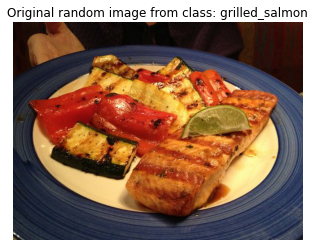

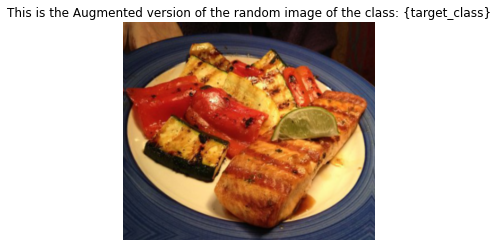

In [155]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class

# Pick a random image 
random_image = random.choice(os.listdir(target_dir))
# the whole path 
random_image_path = target_dir + '/' + random_image

# Visualize this , read in the random image 
img = mpimg.imread(random_image_path)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False)
plt.imshow(img)


# Now plot the augmented version of the image 
augmented_img = data_augmentation(tf.expand_dims(img , axis = 0)) # Adding a batch dimension
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # normalizing because it's not in the right format for matplotlib
plt.axis(False)
plt.title('This is the Augmented version of the random image of the class: {target_class}')

In [131]:
# Normalize 
(tf.expand_dims(img , axis = 0)).shape

TensorShape([1, 384, 512, 3])

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation.

In [132]:
# Setup input and output shape, base model, freeze the base model layers
input_shape = (224 , 224 , 3)
base_model  = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape= input_shape , name = 'input_layer')

# Add in data augmentation Sequential as a layer
x = data_augmentation(inputs)

# Give base model the inputs after they have been augmented (Dont train it)
x = base_model(x , training = False)

# Pool the output features of the base model (condense into feature vector)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)

# Put a dense layer on as the output 
outputs = tf.keras.layers.Dense(10 , activation = 'softmax' , name ='output_layer')(x)

# Make a model using the inputs and outputs 
model_1 = keras.Model(inputs , outputs)


In [133]:
# Compile the model 
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [134]:
# Fit the model 
history_1 = model_1.fit(train_data_1_percent ,
                        epochs = 5 ,
                        steps_per_epoch = len(train_data_1_percent) , 
                        validation_data = test_data , 
                        validation_steps = int(0.2 * len(test_data)) , 
                        callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                 experiment_name = '1_percent_data_aug')])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210324-023956
Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.4325 - accuracy: 0.0930 - val_loss: 2.2168 - val_accuracy: 0.1583
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.2034 - accuracy: 0.1814 - val_loss: 2.1060 - val_accuracy: 0.2604
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9719 - accuracy: 0.3518 - val_loss: 2.0154 - val_accuracy: 0.3187
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7778 - accuracy: 0.4922 - val_loss: 1.9333 - val_accuracy: 0.3917
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6741 - accuracy: 0.6417 - val_loss: 1.8474 - val_accuracy: 0.4625


In [135]:
# Getting the summary of the model
model_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [136]:
# Evalaute on the full test data 
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 10s 119ms/step - loss: 1.8292 - accuracy: 0.4568


[1.8291734457015991, 0.45680001378059387]

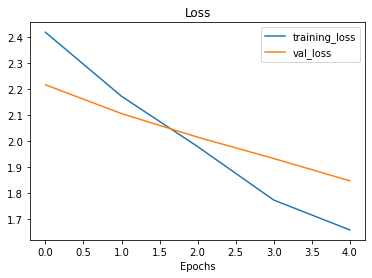

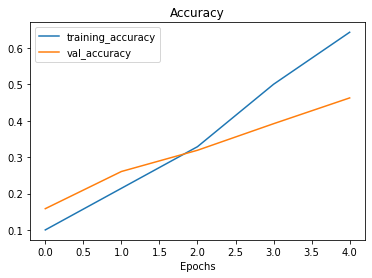

In [137]:
# Getting the loss curve 
plot_loss_curves(history_1)

## Building Model 2 with data augmentation layer and 10% of the training data 

In [138]:
# Getting the data in directories 
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [139]:
# How many images are in each sub-directory? 
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.


In [140]:
# Importing our data in the dataloaders from the directories
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent , 
                                                                            image_size = IMG_SIZE , 
                                                                            batch_size = BATCH_SIZE , 
                                                                            label_mode = 'categorical' , 
                                                                            shuffle = True , 
                                                                            seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir , 
                                                                image_size = IMG_SIZE , 
                                                                batch_size = BATCH_SIZE , 
                                                                label_mode = 'categorical' , 
                                                                seed = 42)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [152]:
# Construct a model for data augmentation with Sequential API
from tensorflow.keras.layers.experimental import preprocessing 


data_augmentation_10_percent = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal') , 
  preprocessing.RandomZoom(0.2) , 
  preprocessing.RandomRotation(0.2) , 
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomHeight(0.2)
] , name = 'data_augmentation_10_percent')

10_food_classes_10_percent/train/sushi


Text(0.5, 1.0, 'This is the Augmented version of the random image of the class: {target_class}')

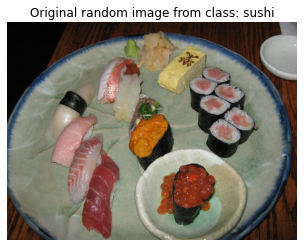

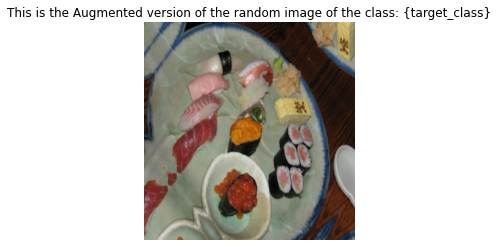

In [162]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_10_percent.class_names)
target_dir = '10_food_classes_10_percent/train/' + target_class
print(target_dir)

# Pick a random image 
random_image = random.choice(os.listdir(target_dir))
# the whole path 
random_image_path = target_dir + '/' + random_image

# Visualize this , read in the random image 
img = mpimg.imread(random_image_path)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False)
plt.imshow(img)


# Now plot the augmented version of the image 
augmented_img = data_augmentation_10_percent(tf.expand_dims(img , axis = 0)) # Adding a batch dimension
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # normalizing because it's not in the right format for matplotlib
plt.axis(False)
plt.title('This is the Augmented version of the random image of the class: {target_class}')

In [ ]:
# Setup input shape at first 
input_shape = (224, 224, 3)

# Setting up our base model (EfficientNet_b0) 
base_model = tf.keras.applications.EfficientN

In [ ]:
# Setup input and output shape, base model, freeze the base model layers
input_shape = (224 , 224 , 3)
base_model  = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape= input_shape , name = 'input_layer')

# Add in data augmentation Sequential as a layer
x = data_augmentation(inputs)

# Give base model the inputs after they have been augmented (Dont train it)
x = base_model(x , training = False)

# Pool the output features of the base model (condense into feature vector)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)

# Put a dense layer on as the output 
outputs = tf.keras.layers.Dense(10 , activation = 'softmax' , name ='output_layer')(x)

# Make a model using the inputs and outputs 
model_1 = keras.Model(inputs , outputs)
